In [6]:
import os
import re
import pandas as pd
import json

folder_path = "/home/snt/projects_lujun/temperature_eval_github/temperature_eval/data/Additional_Results/extent_temperature/evaluation"

dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(folder_path, filename)

        with open(file_path, "r") as file:
            records = [json.loads(line) for line in file if line.strip()]
            df = pd.DataFrame(records)
            if "Llama-3.2-1B-Instruct" in filename:
                model_name = "Llama-3.2-1B-Instruct"
            elif "Meta-Llama-3-8B-Instruct" in filename:
                model_name = "Meta-Llama-3-8B-Instruct"
            elif "Mixtral-8x7B-Instruct-v0.1" in filename:
                model_name = "Mixtral-8x7B-Instruct-v0.1"
            else:
                model_name = "Unknown"
                continue
            df["model_name"] = model_name
            if "accuracy" in df.columns:
                df["accuracy"] = df["accuracy"].astype(float)
            else:
                df["accuracy"] = df.apply(
                    lambda row: (
                        row[f"{row['category']}_accuracy"]
                        if f"{row['category']}_accuracy" in df.columns
                        else None
                    ),
                    axis=1,
                )
            df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")
            df["temperature"] = df["temperature"].apply(
                lambda x: round(x, 2) if pd.notna(x) else x
            )
            columns_to_keep = ["model_name", "temperature", "category", "accuracy"]
            df = df[columns_to_keep]
            dfs.append(df)


folder_path = "/home/snt/projects_lujun/temperature_eval_github/temperature_eval/data/Additional_Results/extent_temperature_with_complementary_4bits/evaluation"


for filename in os.listdir(folder_path):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(folder_path, filename)

        with open(file_path, "r") as file:
            records = [json.loads(line) for line in file if line.strip()]
            df = pd.DataFrame(records)
            if "Llama-3.2-1B-Instruct" in filename:
                model_name = "Llama-3.2-1B-Instruct"
            elif "Meta-Llama-3-8B-Instruct" in filename:
                model_name = "Meta-Llama-3-8B-Instruct"
            elif "Mixtral-8x7B-Instruct-v0.1" in filename:
                model_name = "Mixtral-8x7B-Instruct-v0.1"
            else:
                model_name = "Unknown"
                continue
            df["model_name"] = model_name
            if "accuracy" in df.columns:
                df["accuracy"] = df["accuracy"].astype(float)
            else:
                df["accuracy"] = df.apply(
                    lambda row: (
                        row[f"{row['category']}_accuracy"]
                        if f"{row['category']}_accuracy" in df.columns
                        else None
                    ),
                    axis=1,
                )
            df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")
            df["temperature"] = df["temperature"].apply(
                lambda x: round(x, 2) if pd.notna(x) else x
            )
            columns_to_keep = ["model_name", "temperature", "category", "accuracy"]
            df = df[columns_to_keep]
            dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
# df = df.dropna(subset=["accuracy"])

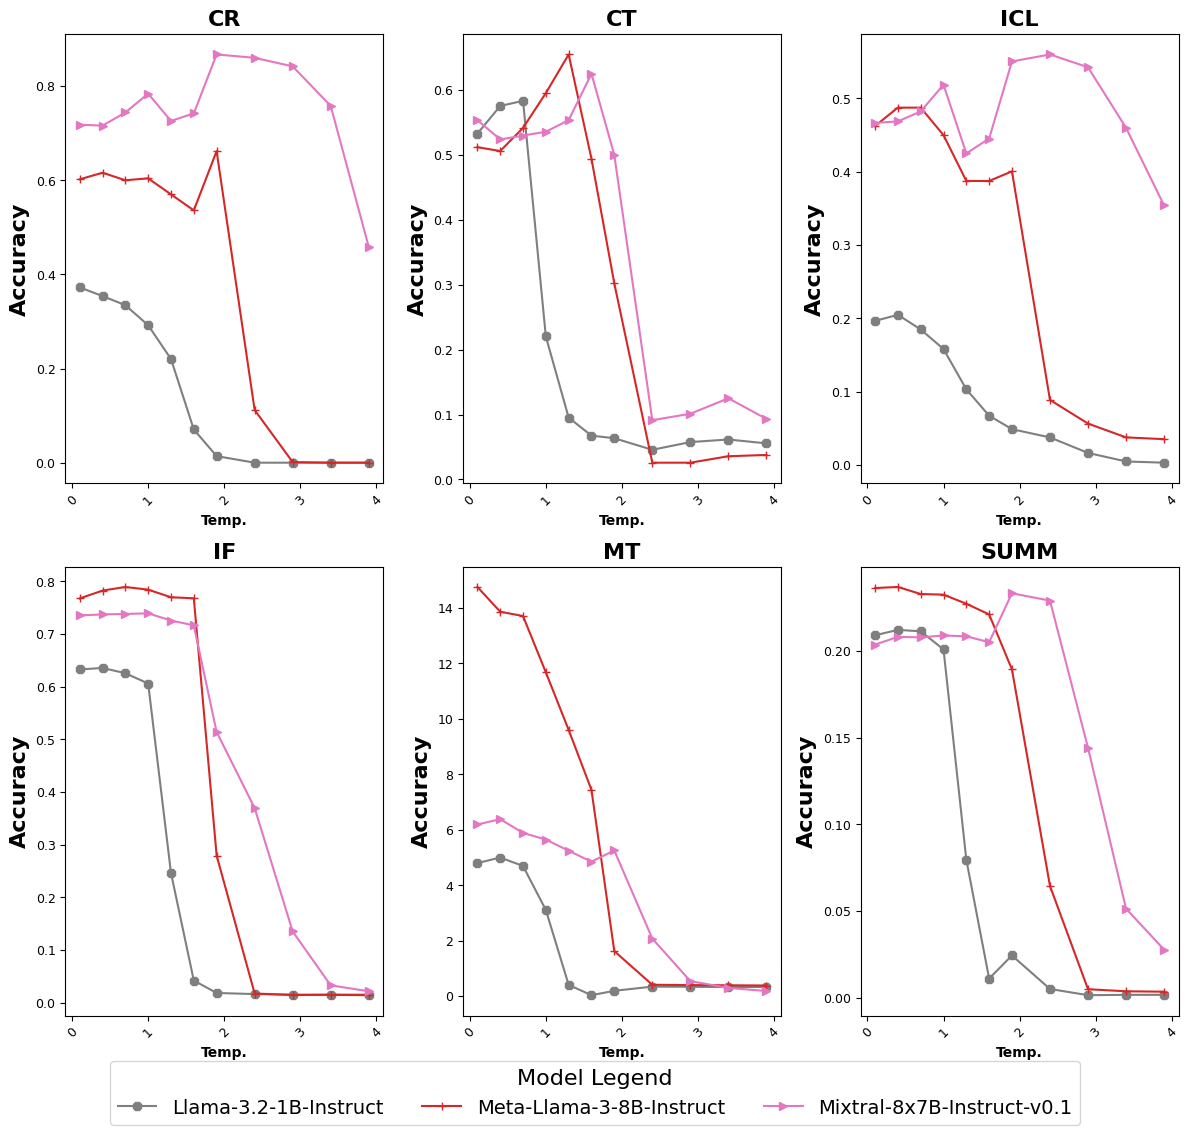

In [41]:
import matplotlib.pyplot as plt

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
    "Llama-3.2-1B-Instruct": "C7",
    "Phi-3.5-mini-instruct": "C8",
    "Phi-3.5-mini-instruct": "C9",
    "Qwen2.5-1.5B-Instruct": "C10",

}
model_order = list(color_map.keys())

markers = [".","*","o","+","^","<",">","8","s","p",",","v","D","d","x","|","_",]
model_marker_map = {model: markers[i] for i, model in enumerate(model_order)}



grouped = (
    df.groupby(["category", "model_name", "temperature"]).accuracy.mean().reset_index()
)

categories = grouped["category"].unique()

fig, axes = plt.subplots(2, 3, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.flatten()
added_labels = set()

for i, category in enumerate(categories[:6]):  # Adjust for a maximum of 6 categories
    ax = axes[i]
    subset = grouped[grouped["category"] == category]
    for model_name in subset["model_name"].unique():
        model_data = subset[subset["model_name"] == model_name]

        if model_name not in added_labels:
            ax.plot(
                model_data["temperature"],
                model_data["accuracy"],
                marker=model_marker_map[model_name],
                color=color_map[model_name],
                label=model_name,
            )
            added_labels.add(model_name)
        else:
            ax.plot(
                model_data["temperature"],
                model_data["accuracy"],
                marker=model_marker_map[model_name],
                color=color_map[model_name],
            )
    ax.set_title(category, fontsize=16,fontweight='bold')
    ax.set_xlabel("Temp.", fontsize=10,fontweight='bold')
    ax.set_ylabel("Accuracy", fontsize=16,fontweight='bold')
    ax.tick_params(axis="y", labelsize=9)

# Remove empty subplots if categories < 6
for j in range(len(categories), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and add shared legend
plt.tight_layout(rect=[0, 0.1, 1, 1])
fig.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 0.05),
    ncol=6,  # Adjust the number of columns in the legend to make it span the full width
    fontsize=14,  # Increase the font size of the legend
    title="Model Legend",
    title_fontsize=16,  # Increase the font size of the legend title
)

plt.savefig("temperature_eval_extend.svg")
plt.show()